In [1]:
#Let's read in some athletes, check their races, and see if a fit model on their first race
#can be used to predict future races.

In [182]:
#Imports borrowed from pymc3_modeling.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.integrate import odeint
size = (12, 9)

import json
import datetime as dt

import re
import os
import glob

import arviz as az
import theano
import theano.tensor as tt
import statsmodels.api as sm
import pymc3 as pm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()
import ast

In [4]:
#Read in the athlete dictionary:
with open("./data/athletes.json") as json_file: 
    athletes = json.load(json_file)

In [34]:
def analyze_file(filepath, sport, athlete_id): #Athlete id is a number no need to pass it the string:
    '''
    This function takes in a file, converts all the columns to numeric and date that we need,
    creates a speed column for running that converts pace to speed in ft/s, and prepares the 
    columns for the fit function that will later be used to predict the running pace. It will 
    create and output all the graphs we have here, for each of the races in the filepath.
    '''
    #Read in the dataframe:
    raw = pd.read_csv(filepath)
    sport = sport
    athlete_max_hr = athletes[str(athlete_id)]['max_hr']
    #Filter down just to the sport:
    df = raw[raw['activity_type'] == sport]
    
    
    #Setting average pace to a timedelta, we use a try in case the data does not have avg_pace column:
    try:
        df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
    except:
        print("No avg_pace column!")
    
    try:
        df['distance'] = pd.to_numeric(df['distance'])
    except:
        print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    try:
        df['elev_gain'] = pd.to_numeric(df['elev_gain'].str.replace(',', ''))
    except:
        try:
            df['elev_gain'] = pd.to_numeric(df['elev_gain'])
        except:
            print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    #Create ft/mile column and intensity for analysis:
    try:
        df['ft_per_mile'] = (df['elev_gain']/df['distance'])
    except:
        df['ft_per_mile']=0
        
    df['intensity'] = df['avg_hr']/athlete_max_hr
    
       
    
    
    
    #Do the same for calculating speed in ft/s
    df['spd_ft_s'] = 0.0
    df['spd_mph'] = 0.0
    df.reset_index(inplace=True)
    
    for i in range(len(df['avg_pace'])):
        try:
        #.total_seconds returns the total seconds in a timedelta object.
            df['spd_mph'][i] = float(60/(df['avg_pace'][i].total_seconds()/60.0))
            #takes the speed in miles per hour and converts down to ft/s
            df['spd_ft_s'][i] = float(60.0/(df['avg_pace'][i].total_seconds()/60.0))*float(5280.0/3600.0)
        except:
            df['spd_mph'][i] = 0
            df['spd_ft_s'][i] = 0
        
    #The default is to be equal to the speed not taking into account elevation gain.
    df['GAP_ft_s'] = df['spd_ft_s']
    
    #Now we try to make a GAP column:
    for i in range(len(df)):
        #Try to make a GAP column:
        try:
            #using trig to calculate the change to the pace:
            factor = (np.sqrt((df['distance'][i]*5280)**2+df['elev_gain'][i]**2)/(df['distance'][i]*5280))
            df['GAP_ft_s'][i] = factor*df['spd_ft_s'][i]
        except:
            print("No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.")
        
    #Why divide by intensity? This brings average run pace up to the speed that we would expect if the athlete was at their highest average
    #sustainable heartrate for this speed. 
    df['GAP_by_intensity']  = df['GAP_ft_s']/df['intensity']
    
    #This creates a finalized dataframe with all of the columns I need for creating the pace curves.
    df.to_csv(filepath[:-4]+'_'+sport+'_extra_cols.csv')

In [7]:
files_to_convert = glob.glob('./data/clean/garmin_clean/*')

In [8]:
files_to_convert

['./data/clean/garmin_clean/clean_6.csv',
 './data/clean/garmin_clean/clean_7.csv',
 './data/clean/garmin_clean/clean_5.csv',
 './data/clean/garmin_clean/clean_4.csv',
 './data/clean/garmin_clean/clean_0.csv',
 './data/clean/garmin_clean/clean_1.csv',
 './data/clean/garmin_clean/clean_3.csv',
 './data/clean/garmin_clean/clean_2.csv',
 './data/clean/garmin_clean/clean_12.csv',
 './data/clean/garmin_clean/clean_11.csv',
 './data/clean/garmin_clean/clean_10.csv',
 './data/clean/garmin_clean/clean_3_Running_extra_cols.csv',
 './data/clean/garmin_clean/clean_9.csv',
 './data/clean/garmin_clean/clean_8.csv']

In [35]:
#Going to do these manually, I am running low on time to automate stuff for now:
analyze_file('./data/clean/garmin_clean/clean_0.csv', 'Running', 0)
analyze_file('./data/clean/garmin_clean/clean_1.csv', 'Running', 1)
analyze_file('./data/clean/garmin_clean/clean_2.csv', 'Running', 2)
analyze_file('./data/clean/garmin_clean/clean_3.csv', 'Running', 3)
analyze_file('./data/clean/garmin_clean/clean_4.csv', 'Running', 4)
analyze_file('./data/clean/garmin_clean/clean_5.csv', 'Running', 5)
analyze_file('./data/clean/garmin_clean/clean_6.csv', 'Running', 6)
analyze_file('./data/clean/garmin_clean/clean_7.csv', 'Running', 7)
analyze_file('./data/clean/garmin_clean/clean_8.csv', 'Running', 8)
analyze_file('./data/clean/garmin_clean/clean_9.csv', 'Running', 9)
analyze_file('./data/clean/garmin_clean/clean_10.csv', 'Running', 10)
analyze_file('./data/clean/garmin_clean/clean_11.csv', 'Running', 11)
analyze_file('./data/clean/garmin_clean/clean_12.csv', 'Running', 12)




Check athlete #2 at filepath ###./data/clean/garmin_clean/clean_2.csv###
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.
No 

Let's see if our Pymc3 fit can be applied to other athlete's races:

In [145]:
def get_athlete_param(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/races/athlete_{athlete_id}/athlete_{athlete_id}_race_0_3_mo_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    
    print('####')
    print(f'Final date in df: {df.index[-1]}')
    print(f"Final race in df: {df[df['is_race']==1]}")
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    pace_trend.index = pd.to_datetime(pace_trend.index).normalize()
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    
    #Reindex and fill the df keeping pace constant until changed.
    full_date_range = pd.date_range(start = pace_trend.index[0], end=pace_trend.index[-1])
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    pace_trend = pace_trend.resample('W').mean()
    print(len(pace_trend))
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    

Athlete Id is 0
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-05-09
Final race in df:             Unnamed: 0  index activity_type  favorite                 title  \
date                                                                          
2020-05-09          31     31       Running     False  Philadelphia Running   

            distance calories      time  avg_hr  max_hr  ...  max_temp  \
date                                                     ...             
2020-05-09     50.01    4,299  08:24:38     169     205  ...       0.0   

            athlete_id filetype is_race  ft_per_mile intensity  spd_ft_s  \
date                                                                       
2020-05-09           0   garmin       1    37.072585  0.965714  8.727273   

             spd_mph  GAP_ft_s  GAP_by_intensity  
date                                              
2020-05-09  5.950413  8.727488          9.037339  

[1 rows x 39 columns]
5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 508.25draws/s]


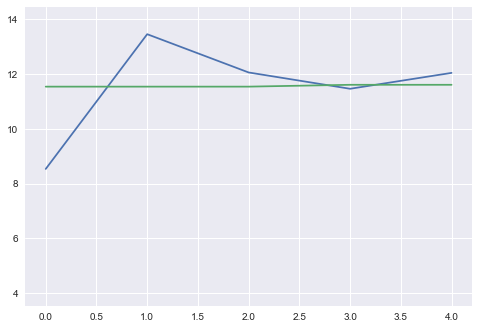

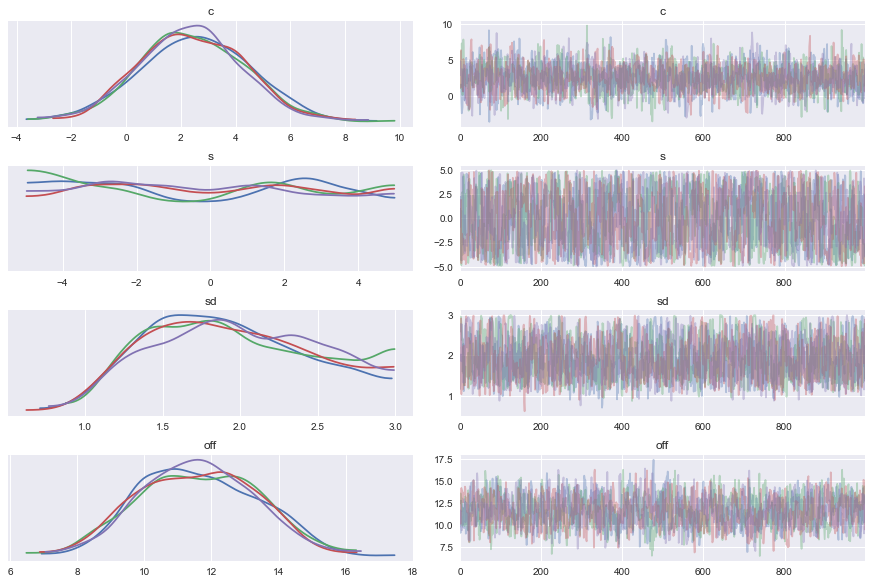

In [157]:
get_athlete_param(0)

Athlete Id is 1
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2017-01-15
Final race in df:             Unnamed: 0  index activity_type  favorite            title  \
date                                                                     
2017-01-15          42     66       Running     False  Houston Running   

            distance calories     time  avg_hr  max_hr  ...  max_resp  \
date                                                    ...             
2017-01-15     26.48    2,722  3:40:52     147     179  ...         0   

            athlete_id  filetype is_race ft_per_mile  intensity  spd_ft_s  \
date                                                                        
2017-01-15           1    garmin       1    7.930514       0.84     10.56   

            spd_mph   GAP_ft_s  GAP_by_intensity  
date                                              
2017-01-15      7.2  10.560012         12.571443  

[1 rows x 54 columns]
13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 383.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


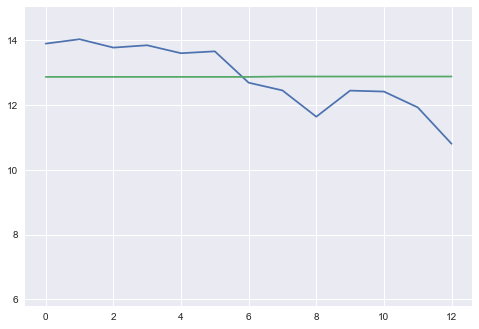

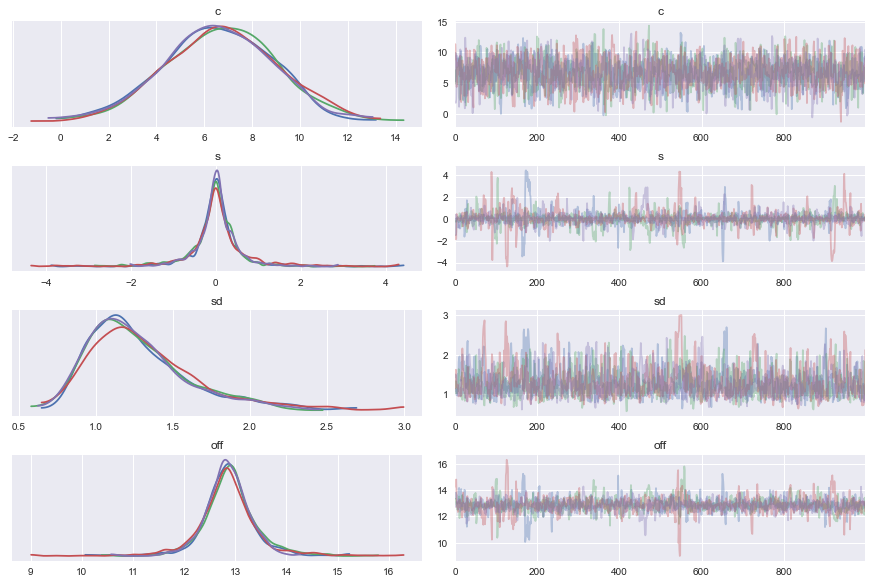

In [156]:
get_athlete_param(1)

Athlete Id is 2
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-02-17
Final race in df: Empty DataFrame
Columns: [Unnamed: 0, index, activity_type, favorite, title, distance, calories, time, avg_hr, max_hr, aerobic_te, avg_run_cadence, max_run_cadence, avg_speed, max_speed, elev_gain, elev_loss, avg_stride_length, avg_vertical_ratio, avg_vertical_oscillation, avg_ground_contact_time, avg_gct_balance, avg_bike_cadence, max_bike_cadence, normalized_powerâ_npâ, training_stress_scoreâ, max_avg_power_20_min, avg_power, max_power, grit, flow, total_strokes, avg__swolf, avg_stroke_rate, climb_time, bottom_time, min_temp, surface_interval, decompression, best_lap_time, number_of_laps, max_temp, race, athlete_id, filetype, is_race, avg_pace, best_pace, ft_per_mile, intensity, spd_ft_s, spd_mph, GAP_ft_s, GAP_by_intensity]
Index: []

[0 rows x 54 columns]
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:10<00:00, 553.91draws/s] 
The acceptance probability does not match the target. It is 0.9012015071483583, but should be close to 0.95. Try to increase the number of tuning steps.


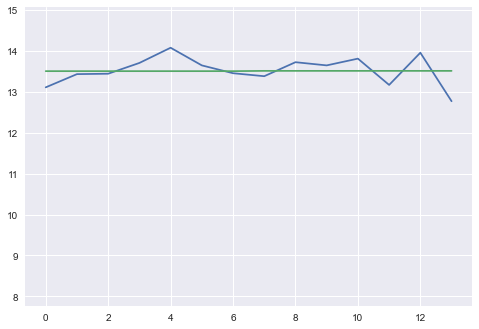

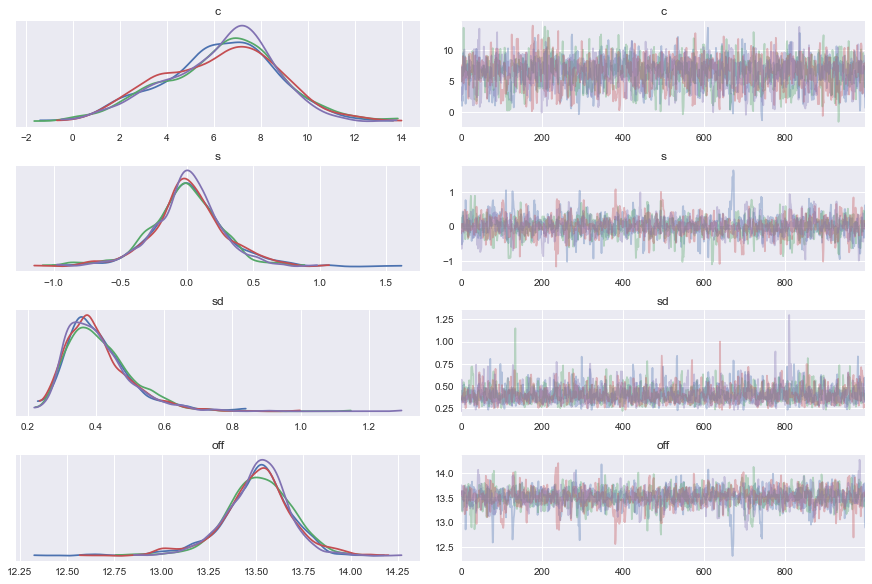

In [155]:
get_athlete_param(2)

Athlete Id is 3
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2018-06-07
Final race in df: Empty DataFrame
Columns: [Unnamed: 0, index, activity_type, favorite, title, distance, calories, time, avg_hr, max_hr, aerobic_te, avg_run_cadence, max_run_cadence, avg_pace, best_pace, elev_gain, elev_loss, avg_stride_length, avg_vertical_ratio, avg_vertical_oscillation, avg_ground_contact_time, avg_gct_balance, avg_run_cadence_1, max_run_cadence_1, normalized_powerâ_npâ, lr_balance, training_stress_scoreâ, max_avg_power_20_min, avg_power, max_power, grit, flow, total_strokes, avg__swolf, avg_stroke_rate, total_reps, total_sets, climb_time, bottom_time, min_temp, surface_interval, decompression, best_lap_time, number_of_laps, max_temp, avg_resp, min_resp, max_resp, athlete_id, filetype, is_race, ft_per_mile, intensity, spd_ft_s, spd_mph, GAP_ft_s, GAP_by_intensity]
Index: []

[0 rows x 57 columns]
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:09<00:00, 610.28draws/s] 
The number of effective samples is smaller than 25% for some parameters.


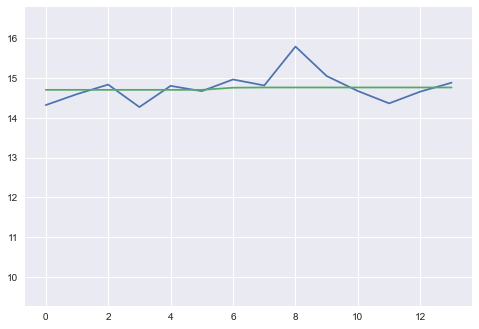

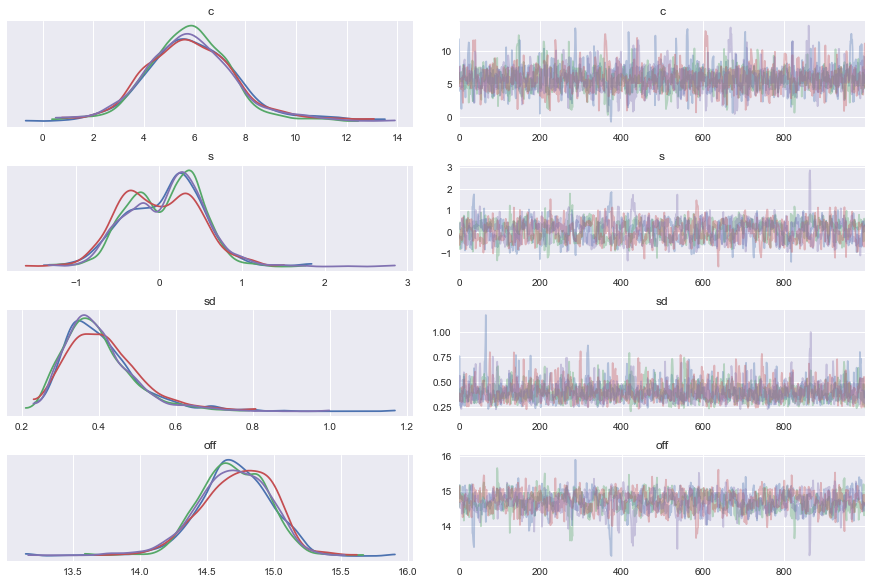

In [143]:
get_athlete_param(3)

Athlete Id is 4
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2018-09-15
Final race in df:             Unnamed: 0  index activity_type  favorite           title  \
date                                                                    
2018-09-15          30     36       Running     False  Morton Running   
2018-09-15          31     37       Running     False  Morton Running   
2018-09-15          32     38       Running     False  Morton Running   

            distance calories        time  avg_hr  max_hr  ...  max_temp  \
date                                                       ...             
2018-09-15      1.03      128  00:09:19.2     139     151  ...       0.0   
2018-09-15      6.21      690    00:36:20     179     191  ...       0.0   
2018-09-15      1.11      156    00:10:52     147     159  ...       0.0   

            athlete_id  filetype is_race ft_per_mile  intensity   spd_ft_s  \
date                                                     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:22<00:00, 261.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


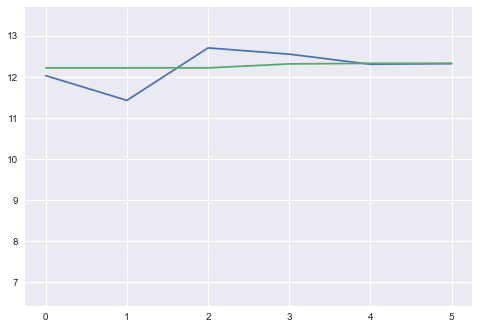

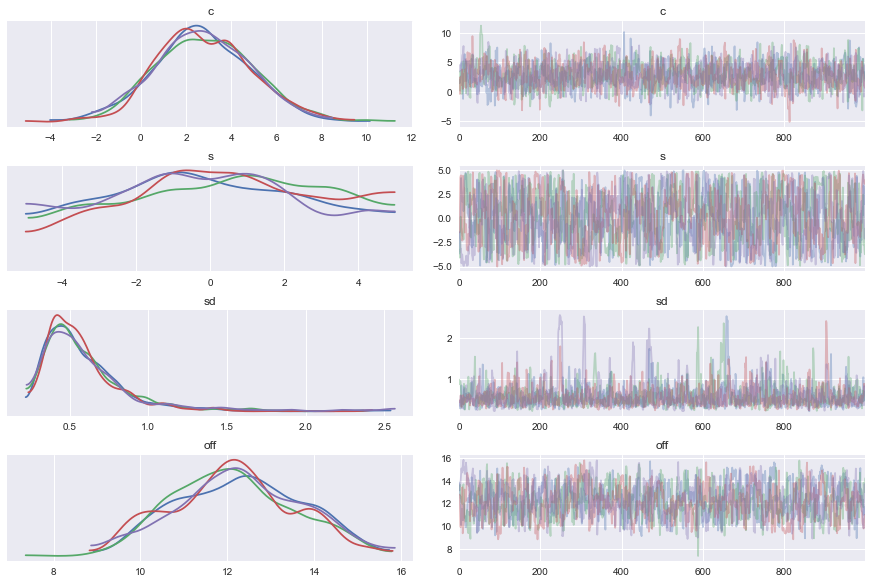

In [146]:
get_athlete_param(4)

Athlete Id is 5
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2018-10-27
Final race in df:             Unnamed: 0  index activity_type  favorite               title  \
date                                                                        
2018-10-27          12     25       Running     False  Cedar Park Running   

            distance calories      time  avg_hr  max_hr  ...  max_temp  \
date                                                     ...             
2018-10-27     13.07    1,844  02:09:22     171     190  ...       0.0   

            athlete_id filetype is_race  ft_per_mile  intensity  spd_ft_s  \
date                                                                        
2018-10-27           5   garmin       1    25.095639   0.977143  8.888889   

             spd_mph  GAP_ft_s  GAP_by_intensity  
date                                              
2018-10-27  6.060606  8.888989          9.096919  

[1 rows x 39 columns]
13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 504.22draws/s]


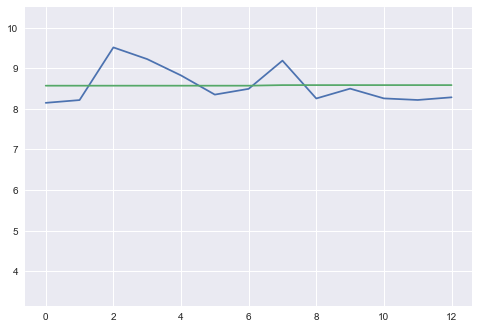

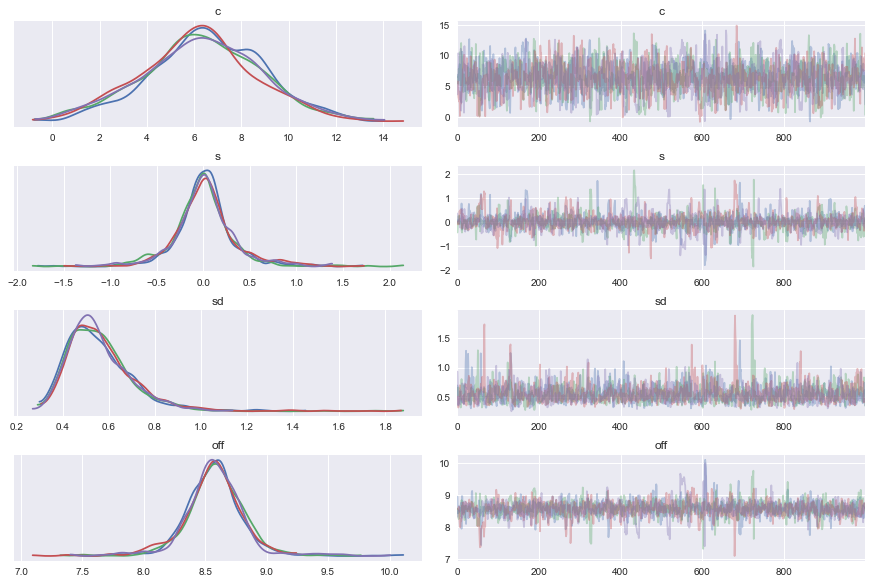

In [147]:
get_athlete_param(5)

Athlete Id is 6
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-10-04
Final race in df: Empty DataFrame
Columns: [Unnamed: 0, index, activity_type, favorite, title, distance, calories, time, avg_hr, max_hr, aerobic_te, avg_run_cadence, max_run_cadence, avg_pace, best_pace, elev_gain, elev_loss, avg_stride_length, avg_vertical_ratio, avg_vertical_oscillation, avg_ground_contact_time, avg_gct_balance, training_stress_scoreâ, grit, flow, total_strokes, avg__swolf, avg_stroke_rate, climb_time, bottom_time, min_temp, surface_interval, decompression, best_lap_time, number_of_laps, max_temp, athlete_id, filetype, is_race, ft_per_mile, intensity, spd_ft_s, spd_mph, GAP_ft_s, GAP_by_intensity]
Index: []

[0 rows x 45 columns]
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:14<00:00, 420.68draws/s]
The number of effective samples is smaller than 25% for some parameters.


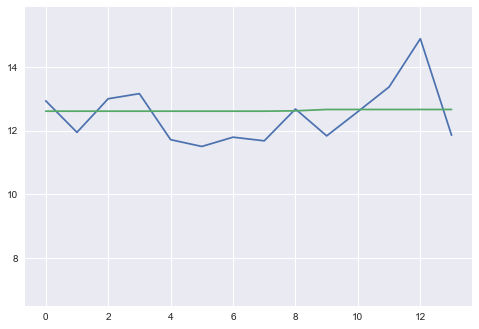

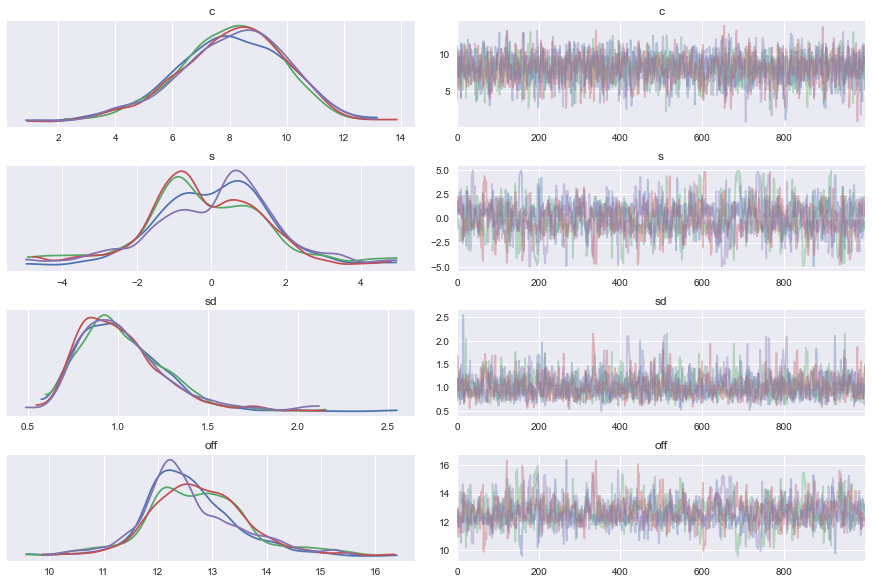

In [148]:
get_athlete_param(6)

Athlete Id is 7
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-10-17
Final race in df:             Unnamed: 0  index activity_type  favorite         title  distance  \
date                                                                            
2020-10-17          37     43       Running     False  Oslo Running      9.96   

           calories      time  avg_hr  max_hr  ...  max_resp  athlete_id  \
date                                           ...                         
2020-10-17      681  00:37:18     174     191  ...        15           7   

            filetype is_race ft_per_mile  intensity   spd_ft_s  spd_mph  \
date                                                                      
2020-10-17    garmin       1    2.911647   0.994286  23.466667     16.0   

            GAP_ft_s  GAP_by_intensity  
date                                    
2020-10-17  23.46667         23.601536  

[1 rows x 50 columns]
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 506.85draws/s]


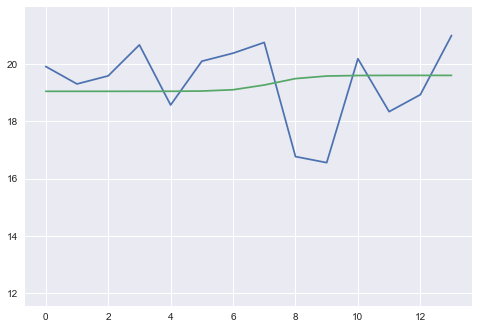

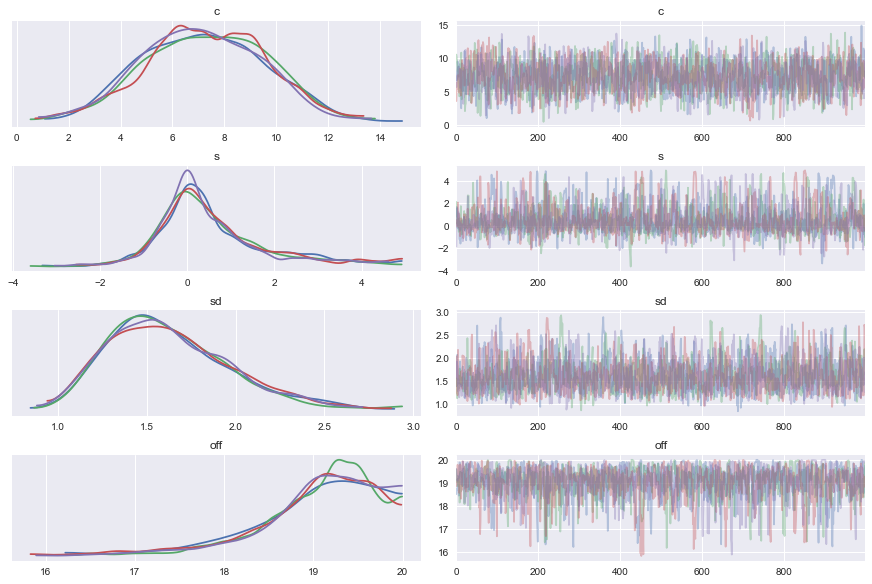

In [149]:
get_athlete_param(7)

Athlete Id is 8
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-05-09
Final race in df:             Unnamed: 0  index activity_type  favorite           title  \
date                                                                    
2020-05-09          45     66       Running     False  Denver Running   
2020-05-09          46     68       Running     False  Denver Running   

            distance calories      time  avg_hr  max_hr  ...  stress_end  \
date                                                     ...               
2020-05-09      2.04      242  00:18:22     157     167  ...           0   
2020-05-09      8.10    1,101  01:24:04     164     182  ...           0   

            athlete_id  filetype is_race ft_per_mile  intensity  spd_ft_s  \
date                                                                        
2020-05-09           8    garmin       1   21.078431   0.897143  9.777778   
2020-05-09           8    garmin       1   31.234568 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 530.01draws/s] 


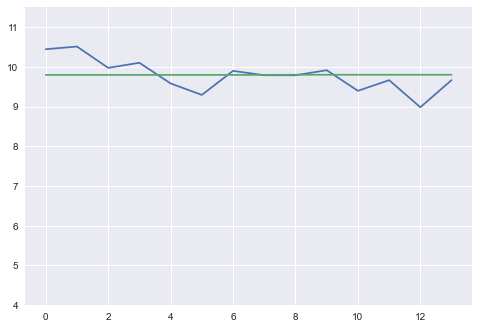

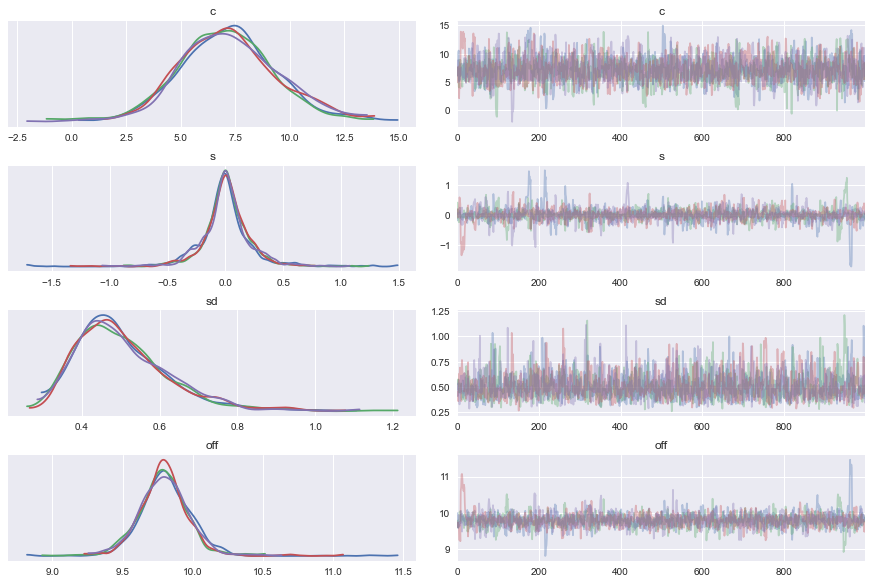

In [150]:
get_athlete_param(8)

Athlete Id is 9
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2016-04-13
Final race in df: Empty DataFrame
Columns: [Unnamed: 0, index, activity_type, favorite, title, distance, calories, time, avg_hr, max_hr, aerobic_te, avg_run_cadence, max_run_cadence, avg_speed, max_speed, elev_gain, elev_loss, avg_stride_length, avg_vertical_ratio, avg_vertical_oscillation, avg_ground_contact_time, avg_gct_balance, avg_bike_cadence, max_bike_cadence, normalized_powerâ_npâ, lr_balance, training_stress_scoreâ, max_avg_power_20_min, avg_power, max_power, grit, flow, total_strokes, avg__swolf, avg_stroke_rate, total_reps, total_sets, climb_time, bottom_time, min_temp, surface_interval, decompression, best_lap_time, number_of_laps, max_temp, athlete_id, filetype, is_race, avg_pace, best_pace, ft_per_mile, intensity, spd_ft_s, spd_mph, GAP_ft_s, GAP_by_intensity]
Index: []

[0 rows x 56 columns]
8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 396.87draws/s]
The acceptance probability does not match the target. It is 0.8844996022992173, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


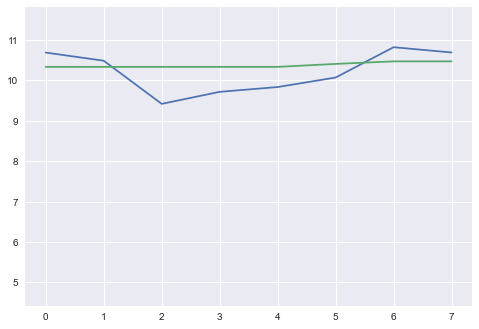

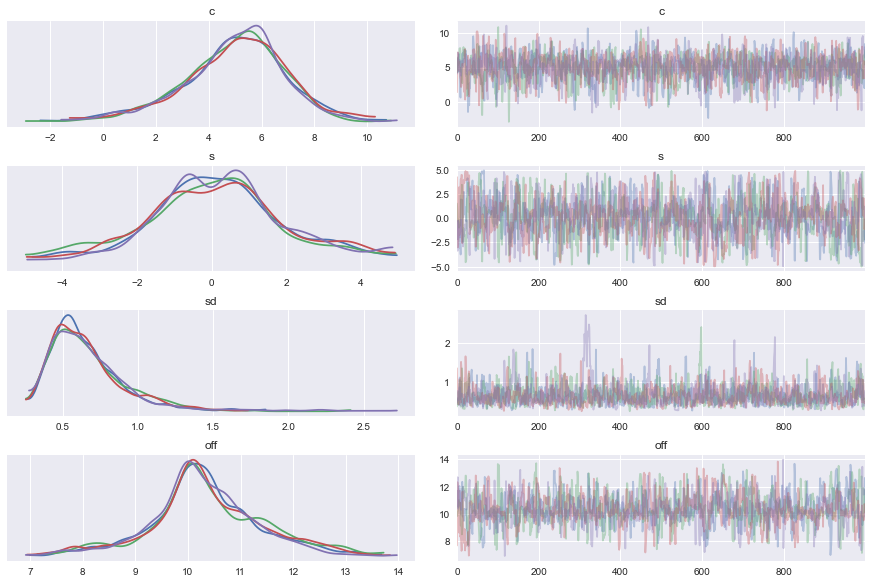

In [151]:
get_athlete_param(9)

Athlete Id is 10
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2018-10-27
Final race in df:             Unnamed: 0  index activity_type  favorite               title  \
date                                                                        
2018-10-27          23     59       Running     False  Cedar Park Running   

            distance calories     time  avg_hr  max_hr  ...  filetype  \
date                                                    ...             
2018-10-27     13.09    1,512  2:27:00     171     193  ...    garmin   

            is_race         avg_pace        best_pace  ft_per_mile  intensity  \
date                                                                            
2018-10-27        1  0 days 00:11:14  0 days 00:11:14    45.378151   0.977143   

            spd_ft_s   spd_mph  GAP_ft_s  GAP_by_intensity  
date                                                        
2018-10-27  7.833828  5.341246  7.834117          8.017371  

[

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 537.94draws/s]
The number of effective samples is smaller than 25% for some parameters.


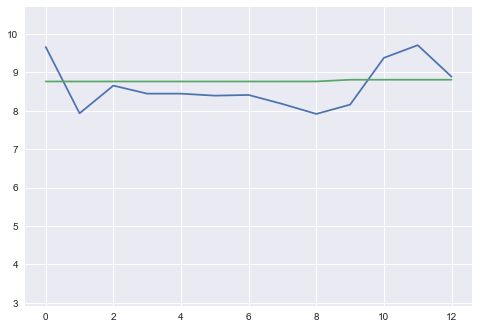

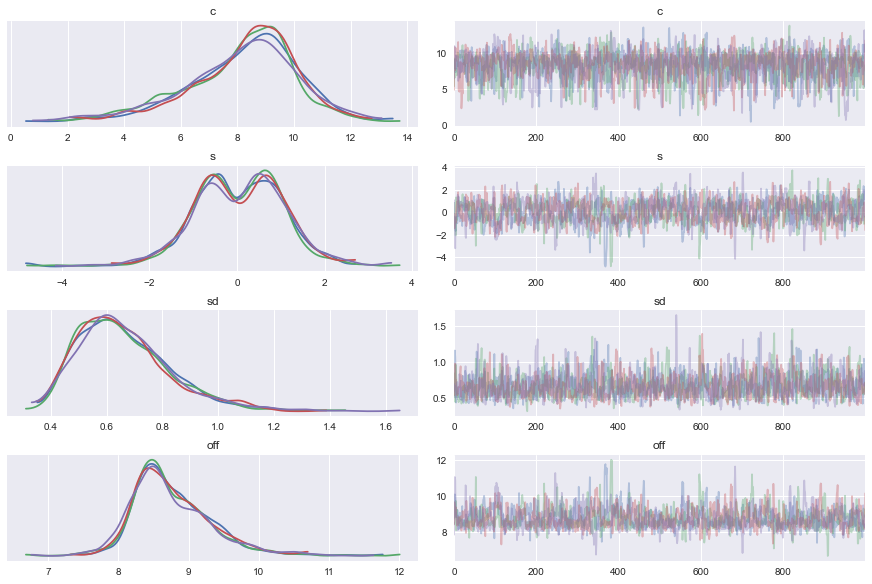

In [152]:
get_athlete_param(10)

Athlete Id is 11
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2021-01-17
Final race in df:             Unnamed: 0  index activity_type  favorite               title  \
date                                                                        
2021-01-17          26     27       Running     False  Sugar Land Running   

            distance calories      time  avg_hr  max_hr  ...  max_temp  \
date                                                     ...             
2021-01-17     13.27      875  01:35:21     146     171  ...       0.0   

            athlete_id  filetype is_race ft_per_mile  intensity  spd_ft_s  \
date                                                                        
2021-01-17          11    garmin       1    15.07159   0.853801  12.25058   

             spd_mph  GAP_ft_s  GAP_by_intensity  
date                                              
2021-01-17  8.352668  12.25063         14.348341  

[1 rows x 40 columns]
14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 434.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


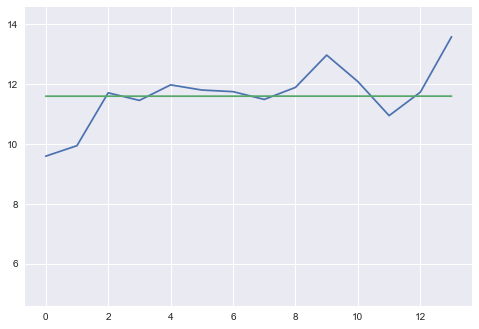

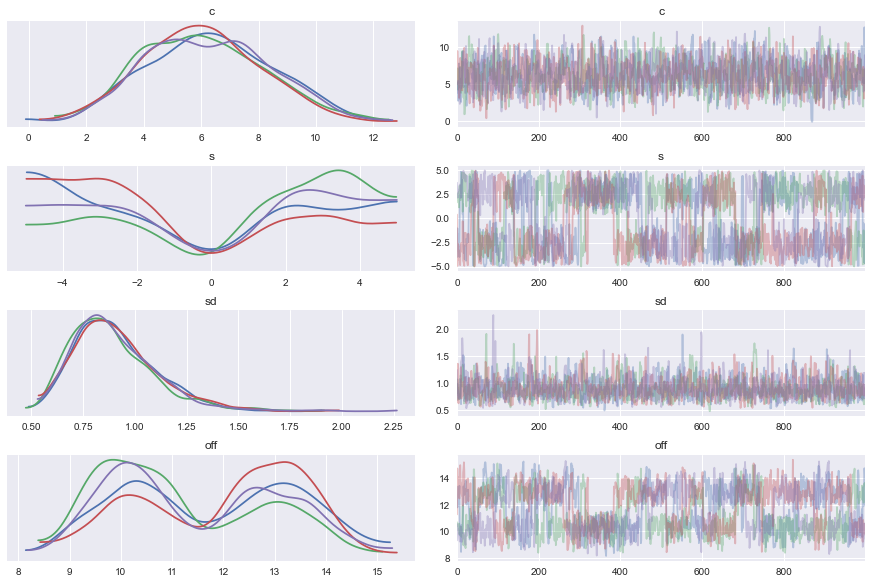

In [153]:
get_athlete_param(11)

Athlete Id is 12
Dataframe read in successfully.
Pace Trend found.
####
Final date in df: 2020-08-15
Final race in df:             Unnamed: 0  index activity_type  favorite                   title  \
date                                                                            
2020-07-11          37     58       Running      True    Lemhi County Running   
2020-08-15          50     88       Running      True  Larimer County Running   

            distance calories      time  avg_hr  max_hr  ...  max_resp  \
date                                                     ...             
2020-07-11     60.68    8,760  16:54:37     140     189  ...        17   
2020-08-15     25.37    3,379  05:19:08     157     175  ...        45   

            athlete_id  filetype is_race ft_per_mile  intensity  spd_ft_s  \
date                                                                        
2020-07-11          12    garmin       1  185.234015   0.818713  5.264207   
2020-08-15          12    ga

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 431.88draws/s]
The number of effective samples is smaller than 25% for some parameters.


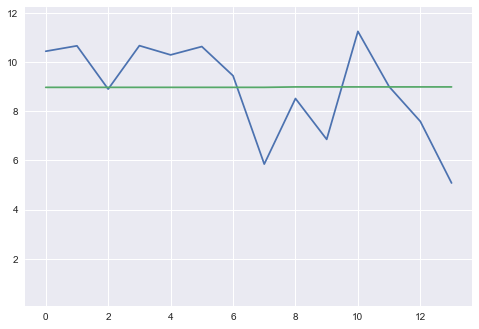

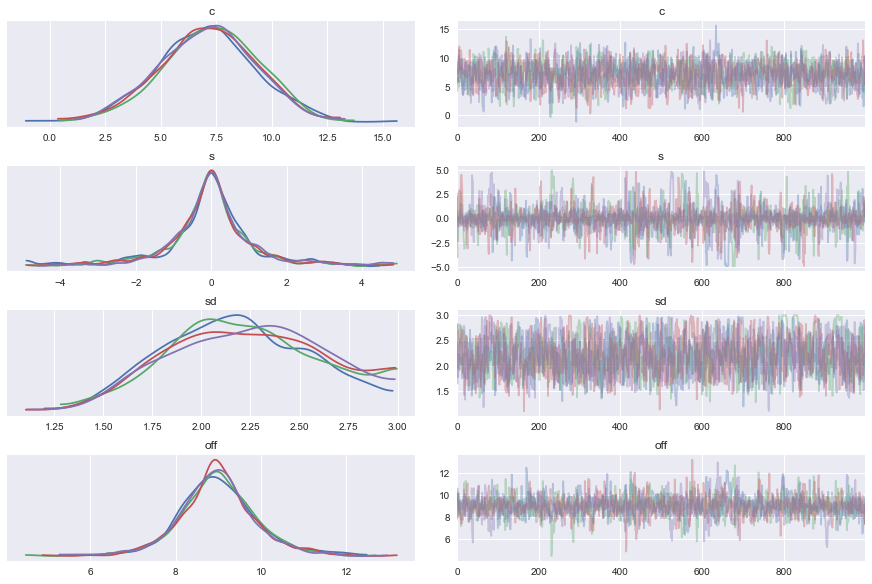

In [154]:
get_athlete_param(12)

In [158]:
#These outputs are confirming what I had already found - that a linear relationship is the best way to predict race pace 3 months out.

In [159]:
#One last function, to recreate what we have in 07_advanced_forecasting:

In [160]:
#The reason the forecasting worked, and the real value of forecasting, is being able to predict out to a race farther in the future with a known athlete characteristic.


In [161]:
#So, we will try to model the training curve as the athlete starts up a season, and then measure that athlete characteristic.
#A prediction will be made on the race in the subsequent season.

In [401]:
def get_season_param(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    
   
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2018-08-07', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2018-08-07':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = 0, upper = 2)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 4
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2018-09-15
513
normalized = DatetimeIndex(['2021-02-01', '2021-01-30', '2021-01-29', '2021-01-28',
               '2021-01-26', '2021-01-24', '2021-01-23', '2021-01-21',
               '2021-01-20', '2021-01-19',
               ...
               '2018-08-21', '2018-08-20', '2018-08-19', '2018-08-18',
               '2018-08-16', '2018-08-14', '2018-08-09', '2018-08-08',
               '2018-08-07', '2018-08-07'],
              dtype='datetime64[ns]', name='date', length=513, freq=None)
Index style is: 2021-02-01 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 439.23draws/s] 


1.1278908134190466


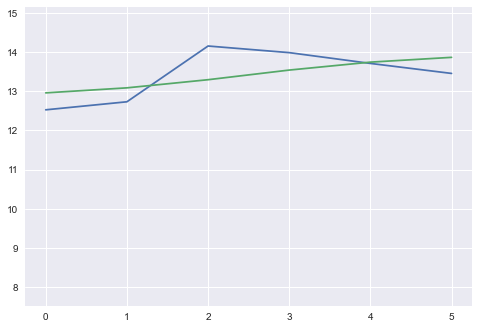

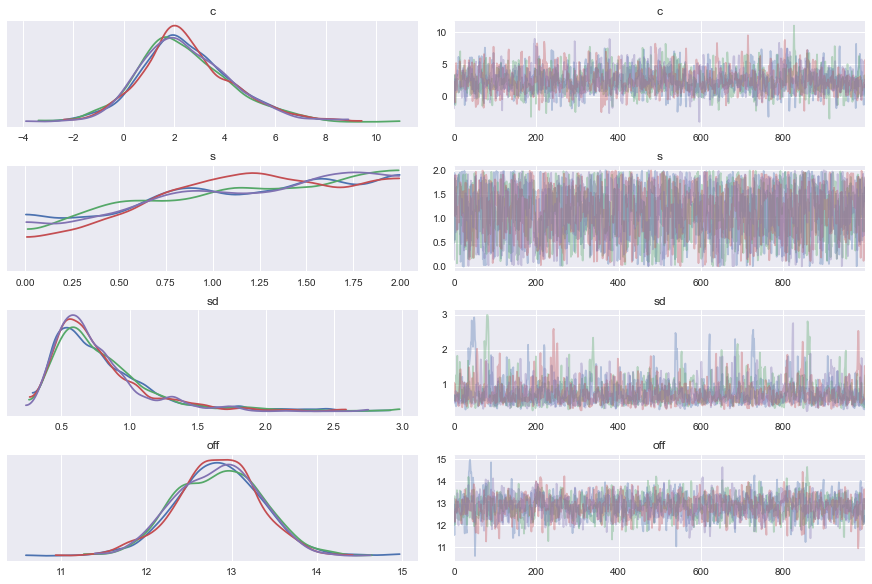

In [402]:
get_season_param(4)

In [380]:
def get_season_param2(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    
   
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2018-03-25', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2018-03-25':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 2
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2020-02-22
574
normalized = DatetimeIndex(['2021-01-22', '2021-01-18', '2021-01-17', '2021-01-16',
               '2021-01-15', '2021-01-14', '2021-01-13', '2021-01-12',
               '2021-01-11', '2021-01-10',
               ...
               '2018-04-15', '2018-04-13', '2018-04-11', '2018-04-07',
               '2018-04-06', '2018-04-03', '2018-04-01', '2018-03-31',
               '2018-03-28', '2018-03-25'],
              dtype='datetime64[ns]', name='date', length=574, freq=None)
Index style is: 2021-01-22 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 504.02draws/s] 
The number of effective samples is smaller than 10% for some parameters.


-0.01313136680144404


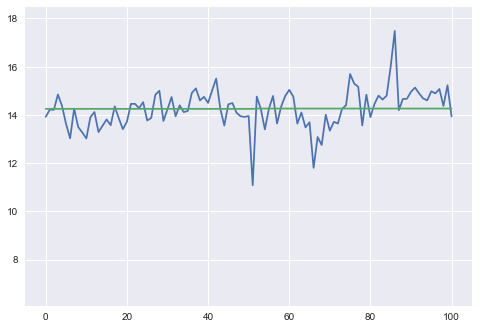

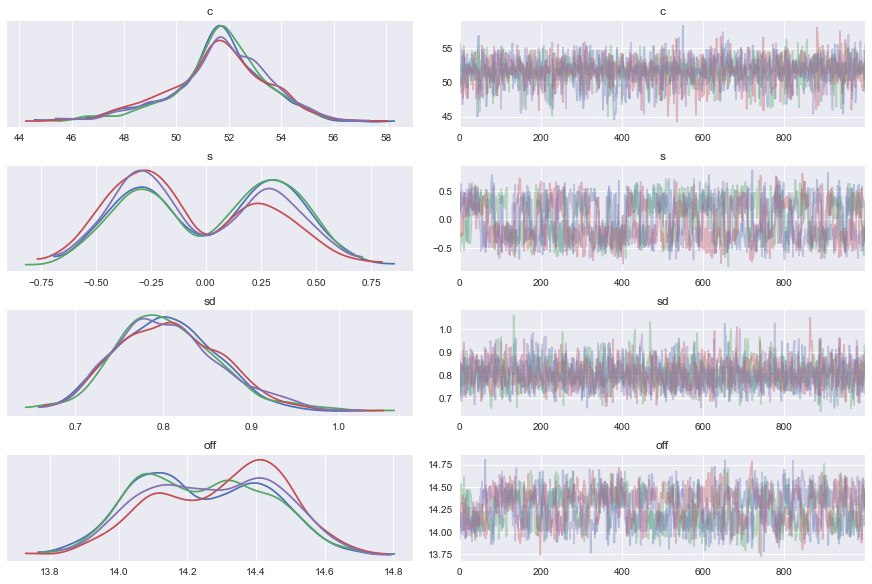

In [381]:
get_season_param2(2)

In [382]:
def get_season_param5(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2018-08-04', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2018-08-04':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 5
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2018-10-27
194
normalized = DatetimeIndex(['2021-01-24', '2021-01-19', '2021-01-14', '2021-01-12',
               '2021-01-04', '2020-12-16', '2020-12-08', '2020-11-29',
               '2020-11-26', '2020-11-24',
               ...
               '2018-10-04', '2018-10-02', '2018-09-25', '2018-09-15',
               '2018-09-09', '2018-09-02', '2018-08-23', '2018-08-14',
               '2018-08-12', '2018-08-04'],
              dtype='datetime64[ns]', name='date', length=194, freq=None)
Index style is: 2021-01-24 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 458.69draws/s]


-0.022244495758010515


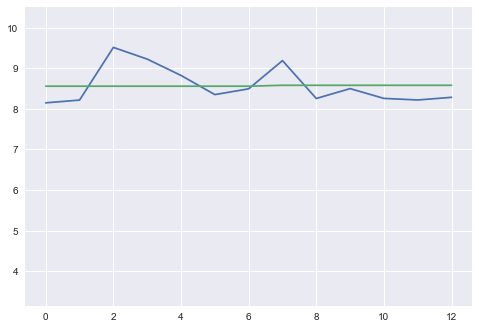

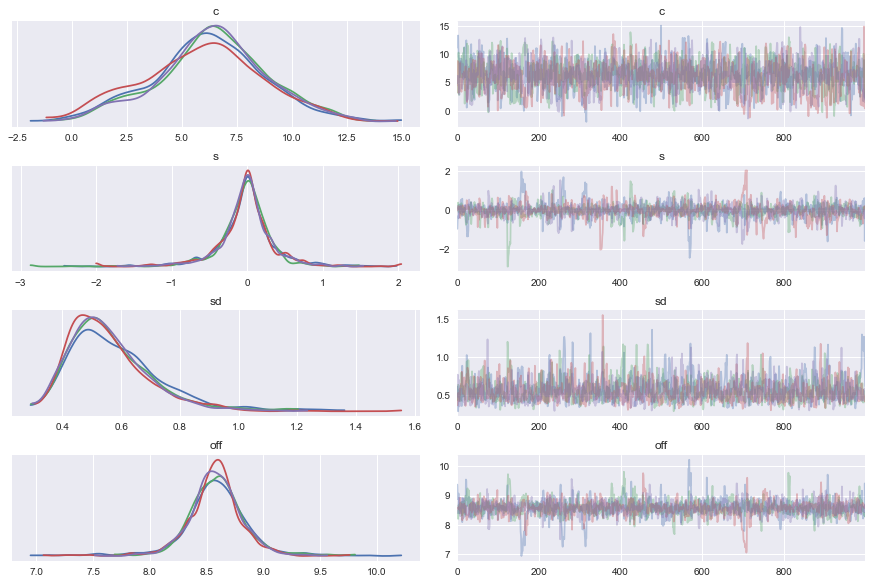

In [383]:
get_season_param5(5)

In [384]:
def get_season_param8(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2019-11-25', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2019-11-25':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 8
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2020-05-09
168
normalized = DatetimeIndex(['2021-01-27', '2021-01-24', '2021-01-22', '2021-01-20',
               '2021-01-16', '2021-01-14', '2021-01-10', '2021-01-06',
               '2020-12-31', '2020-12-29',
               ...
               '2019-12-12', '2019-12-11', '2019-12-10', '2019-12-07',
               '2019-12-07', '2019-12-04', '2019-12-03', '2019-12-01',
               '2019-11-26', '2019-11-25'],
              dtype='datetime64[ns]', name='date', length=168, freq=None)
Index style is: 2021-01-27 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:14<00:00, 419.59draws/s]


-0.0010160133102765695


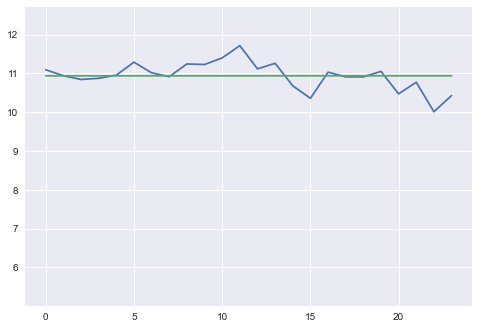

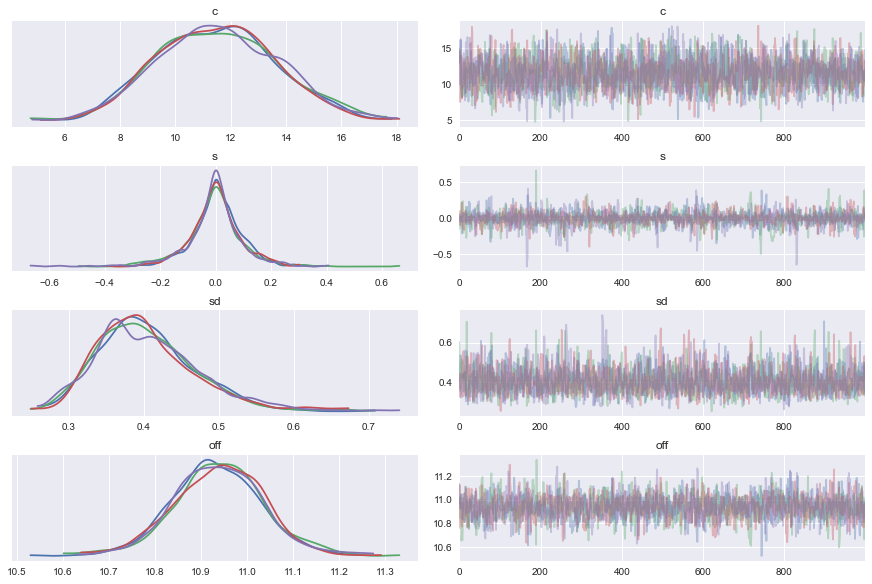

In [385]:
get_season_param8(8)

In [386]:
def get_season_param9(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2016-02-07', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2016-02-07':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 9
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2016-04-12
529
normalized = DatetimeIndex(['2021-01-29', '2021-01-19', '2021-01-15', '2021-01-12',
               '2021-01-05', '2021-01-03', '2021-01-01', '2020-12-30',
               '2020-12-29', '2020-12-27',
               ...
               '2016-04-19', '2016-04-17', '2016-04-13', '2016-04-05',
               '2016-04-04', '2016-03-30', '2016-03-16', '2016-03-06',
               '2016-02-26', '2016-02-25'],
              dtype='datetime64[ns]', name='date', length=529, freq=None)
Index style is: 2021-01-29 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:35<00:00, 170.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


0.08347315914048219


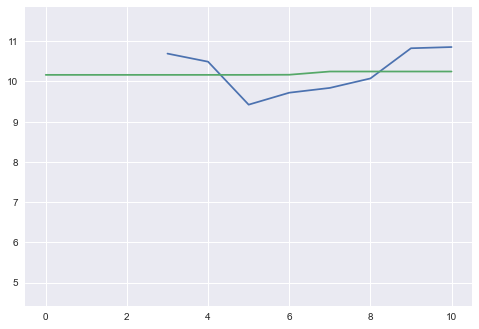

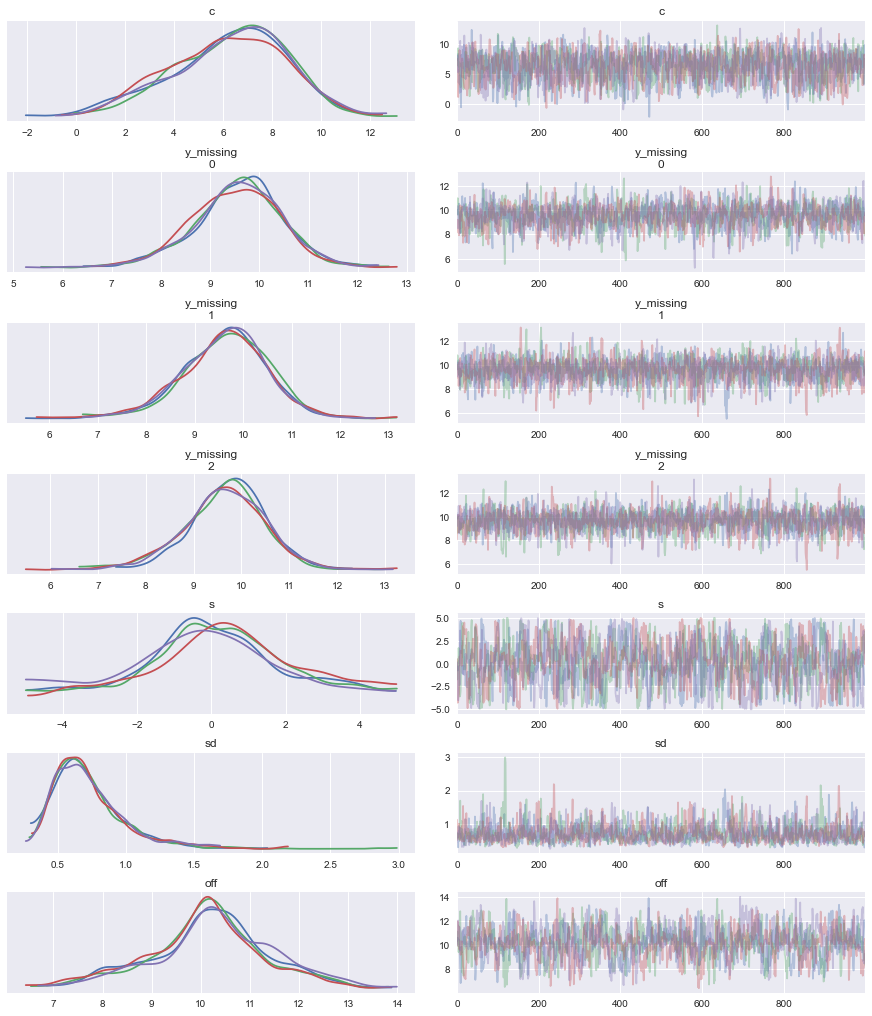

In [388]:
get_season_param9(9)

In [389]:
def get_season_param10(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2018-07-20', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2018-07-20':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 10
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2018-10-27
292
normalized = DatetimeIndex(['2021-01-22', '2021-01-18', '2021-01-11', '2021-01-04',
               '2020-12-29', '2020-12-27', '2020-12-26', '2020-12-22',
               '2020-12-17', '2020-12-12',
               ...
               '2018-09-11', '2018-09-10', '2018-09-06', '2018-09-06',
               '2018-08-20', '2018-08-12', '2018-08-06', '2018-08-01',
               '2018-07-31', '2018-07-25'],
              dtype='datetime64[ns]', name='date', length=292, freq=None)
Index style is: 2021-01-22 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:20<00:00, 291.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


0.01622719223108327


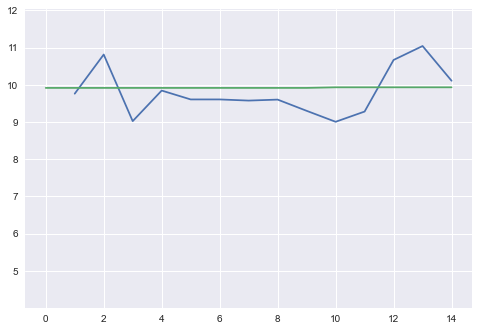

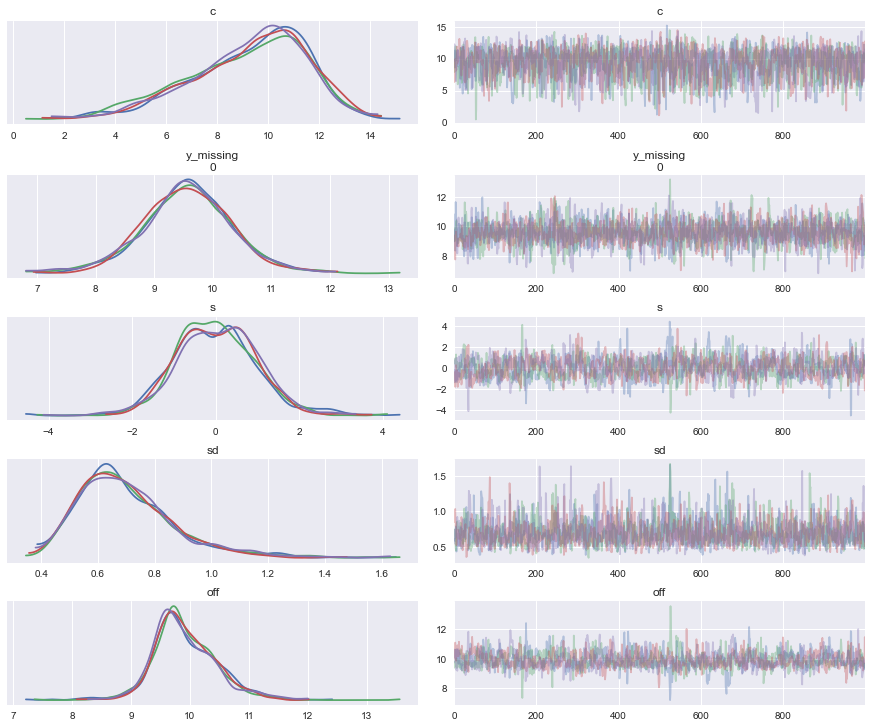

In [390]:
get_season_param10(10)

In [409]:
def get_season_param11(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2020-10-10', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2020-10-10':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = 0, upper = 2)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())
    print(pace_trend[:-3])

Athlete Id is 11
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2021-01-17
30
normalized = DatetimeIndex(['2021-01-17', '2021-01-14', '2021-01-11', '2021-01-04',
               '2020-12-28', '2020-12-25', '2020-12-20', '2020-12-17',
               '2020-12-13', '2020-12-12', '2020-12-12', '2020-12-10',
               '2020-12-06', '2020-11-29', '2020-11-24', '2020-11-21',
               '2020-11-15', '2020-11-14', '2020-11-10', '2020-11-10',
               '2020-11-07', '2020-11-05', '2020-11-03', '2020-10-29',
               '2020-10-24', '2020-10-18', '2020-10-17', '2020-10-15',
               '2020-10-11', '2020-10-10'],
              dtype='datetime64[ns]', name='date', freq=None)
Index style is: 2021-01-17 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:12<00:00, 482.64draws/s]


1.3984483899867008
2020-10-11    12.794440
2020-10-18    12.844452
2020-10-25    12.088746
2020-11-01    14.236845
2020-11-08    13.929086
2020-11-15    14.640795
2020-11-22    14.350088
2020-11-29    14.284362
2020-12-06    13.968302
2020-12-13    14.711868
2020-12-20    15.771132
2020-12-27    14.692816
Freq: W-SUN, dtype: float64


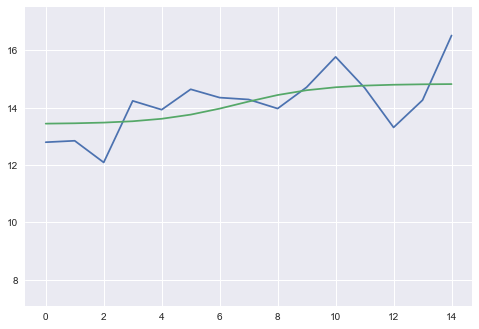

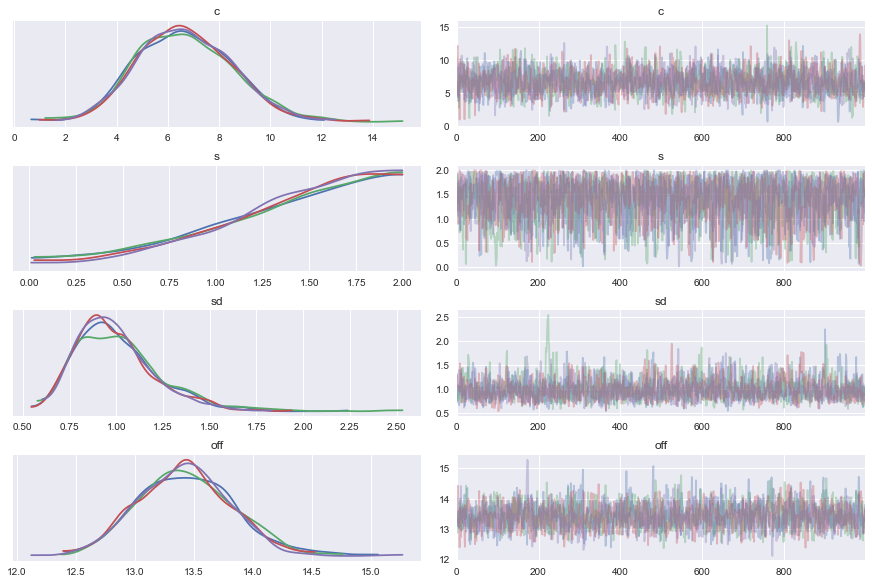

In [410]:
get_season_param11(11)

In [393]:
def get_season_param12(athlete_id):
    '''
    Function takes in an athlete, and calculates their expected athlete characteristic 
    variable.
    '''
    print(f'Athlete Id is {athlete_id}')
    df= pd.read_csv(f'./data/clean/garmin_clean/clean_{athlete_id}_Running_extra_cols.csv', index_col='date')
    print('Dataframe read in successfully.')
    pace_trend = df['spd_ft_s']/df['intensity']
    print('Pace Trend found.')
    #print(len(pace_trend.index))
    
    with open("./data/athletes.json") as json_file: 
        athletes = json.load(json_file)
    
    #print(athletes[str(athlete_id)]['race_date_list'])
    #literally evaluate the string as a list
    race_list = ast.literal_eval(athletes[str(athlete_id)]['race_date_list'])
    
    print('####')
    
    print(f"First race in df: {race_list[0]}")
    print(len(pace_trend.index))
    
    #Convert the index to a date time and drop any duplicates (sometimes runners have two runs a day)
    
    pace_trend.index = pd.to_datetime(pace_trend.index).floor('d')
    
    
    print("normalized = "+str(pace_trend.index))
    print(f"Index style is: {pace_trend.index[0]}")
    #print(f'Final date in df: {df.index[-1]}')
    pace_trend = pace_trend[~pace_trend.index.duplicated(keep='first')]
    #Reindex and fill the df keeping pace constant until changed.
    
    full_date_range = pd.date_range(start = '2020-03-18', end = race_list[0])
    
    pace_trend = pace_trend.reindex(index = full_date_range)
    pace_trend = pace_trend.fillna(method='pad')
    
    
    #Cut the df short
    
    pace_trend = pace_trend['2020-03-18':race_list[0]]
    
    #Resample to weekly:
    pace_trend = pace_trend.resample('W').mean()
    
    #Instantiate and fit a nn:
    x = range(len(pace_trend))
    
    with pm.Model() as run_model:
    
        s = pm.Uniform('s', lower = -5, upper = 5)
        c = pm.Normal('c', mu = len(pace_trend)/2, sd = 2)
        sd = pm.Uniform('sd', lower = 0, upper = 3)
        offset = pm.Uniform('off', lower = 3, upper = 20)
        line = s/(1+np.exp((-(x-c))/s)) + offset
        y = pm.Normal('y', mu = line, sd = sd, observed = pace_trend)

        trace = pm.sample(1000, target_accept = 0.95)
    plt.plot(x, pace_trend)
    s_final = trace['s'].mean()
    c_final = trace['c'].mean()
    off_final = trace['off'].mean()
    plt.plot(x, (s_final/(1+np.exp((-(x-c_final))/s_final)) + off_final))
    #print(pace_trend.max())
    plt.ylim(pace_trend.min()-5, pace_trend.max()+1)
    
   
    az.plot_trace(trace)
    print(trace['s'].mean())

Athlete Id is 12
Dataframe read in successfully.
Pace Trend found.
####
First race in df: 2020-08-15
101
normalized = DatetimeIndex(['2021-02-16', '2021-02-13', '2021-02-11', '2021-02-05',
               '2021-02-04', '2021-02-02', '2021-01-15', '2021-01-13',
               '2021-01-09', '2021-01-07',
               ...
               '2020-04-05', '2020-04-04', '2020-04-02', '2020-03-31',
               '2020-03-28', '2020-03-27', '2020-03-26', '2020-03-24',
               '2020-03-21', '2020-03-19'],
              dtype='datetime64[ns]', name='date', length=101, freq=None)
Index style is: 2021-02-16 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 522.89draws/s]


0.007002101346957408


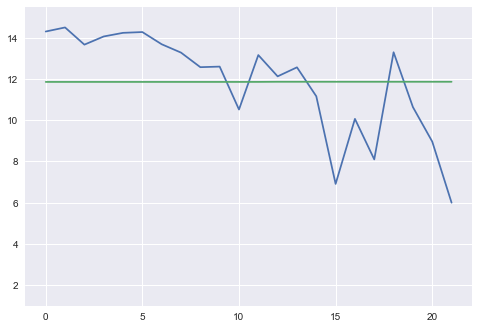

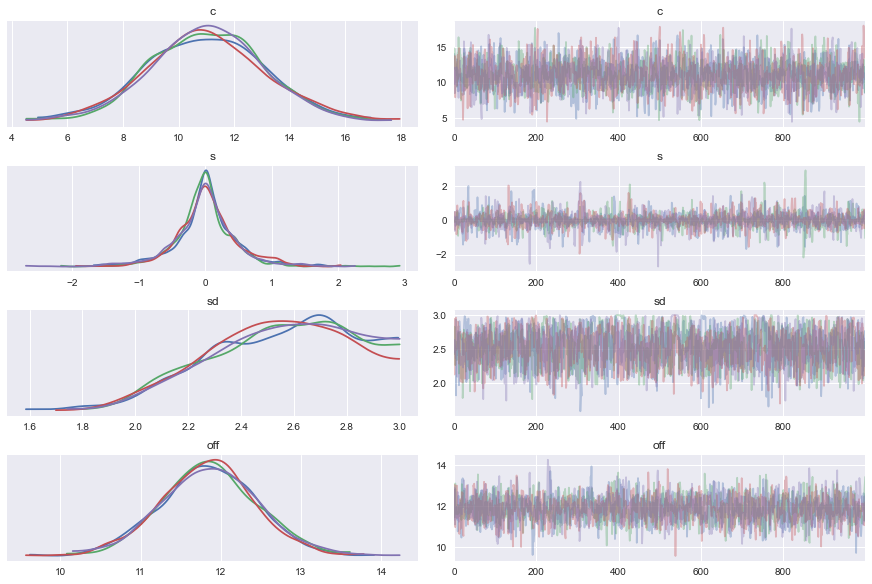

In [394]:
get_season_param12(12)

In [403]:
#Let's predict for athlete 11, one of the few with a positive curve:

s = 1.41  
c = 48 days / 7 = 7 weeks /2 = 3.5  
offset = 14.2 ft/s

In [404]:
#offset was calculated as average of the last 4 runs divided by intensity.

In [412]:
def new_line(x):
    return 1.41/(1+np.exp((-(x-3.5))/1.41)) + 14.2

In [413]:
x = np.linspace(0, 7, 7)

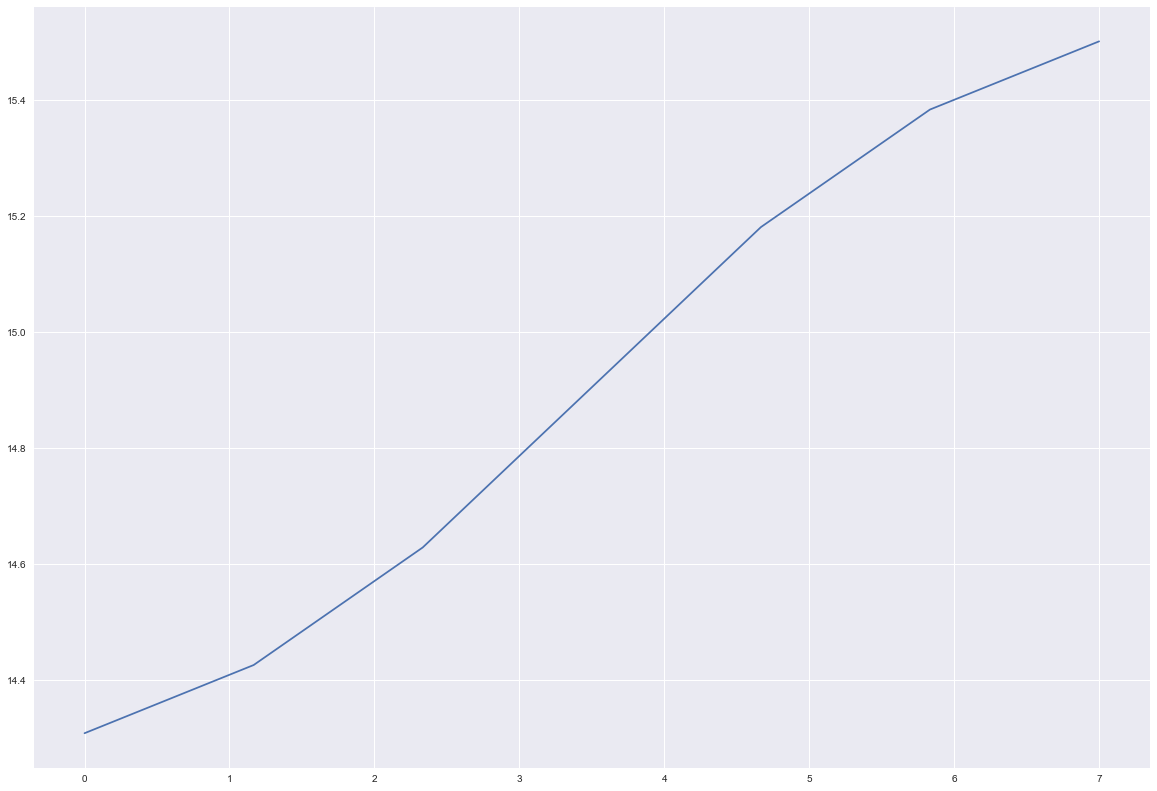

In [414]:
plt.figure(figsize=(20,14))
plt.plot(x, new_line(x))

15.4 * .75 marathon intensity gives us 7:37/mile. We will have to see how she does!

In [415]:
#The athlete took a break for a week, because they were planning on racing a race within this 7 week time frame. So I will subtract 2 weeks from the estimation:

In [416]:
def new_line(x):
    return 1.41/(1+np.exp((-(x-2.5))/1.41)) + 14.2

In [417]:
x = np.linspace(0, 5, 5)

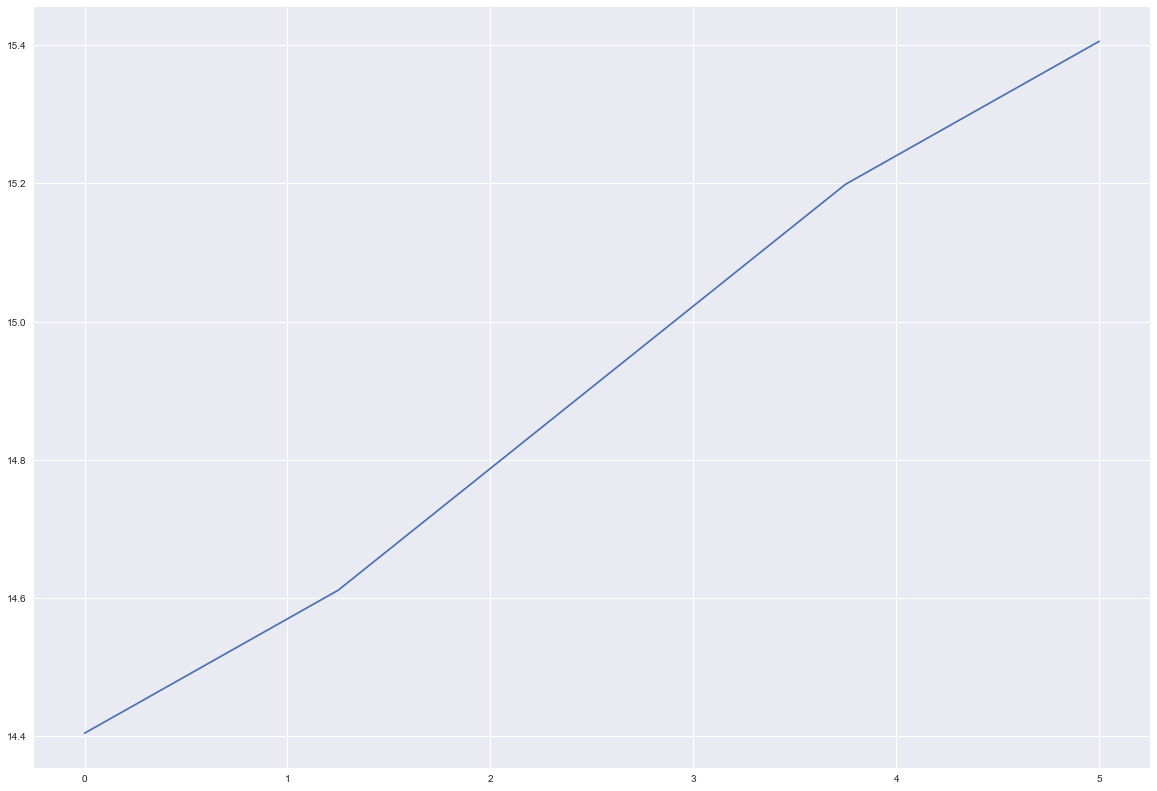

In [418]:
plt.figure(figsize=(20,14))
plt.plot(x, new_line(x))